<a href="https://colab.research.google.com/github/sangeethaperumalse/applied-machine-learning/blob/main/Sangeetha_Deep_Fake_Voice_Recognition_VGGish_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [ ]:
!pip install -q kaggle
!kaggle datasets download -d birdy654/deep-voice-deepfake-voice-recognition
!unzip /content/deep-voice-deepfake-voice-recognition.zip

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition
License(s): other
... resuming from 308281344 bytes (3648558995 bytes left) ...
100% 3.67G/3.69G [00:47<00:00, 107MB/s]
100% 3.69G/3.69G [00:47<00:00, 76.7MB/s]
Archive:  /content/deep-voice-deepfake-voice-recognition.zip
  inflating: DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3  
  inflating: DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3  
  inflating: KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav  
  inflating: KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-Obama.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-Trump.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-linus.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-margot.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-musk.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-ryan.wav  
  inflating: KAGGLE/AUDIO/FAKE/biden-to-taylor.wav  
  inflating: KAGGLE/AUDIO/FAKE/linus-to-biden.wav  
  inflating: KAGGLE/AUDIO/FAKE/li

# Import Libraries

In [ ]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Load Data

In [ ]:
audio_files_path = "/content/test_audio/AUDIO"

In [ ]:
folders = os.listdir(audio_files_path)
print(folders)

['FAKE', 'REAL']


In [ ]:
real_audio = "/content/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "/content/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

# Visualization

In [ ]:
print("Real Audio:")
#IPython.display.Audio(real_audio)

Real Audio:


In [ ]:
print("Fake Audio:")
#IPython.display.Audio(fake_audio)

Fake Audio:


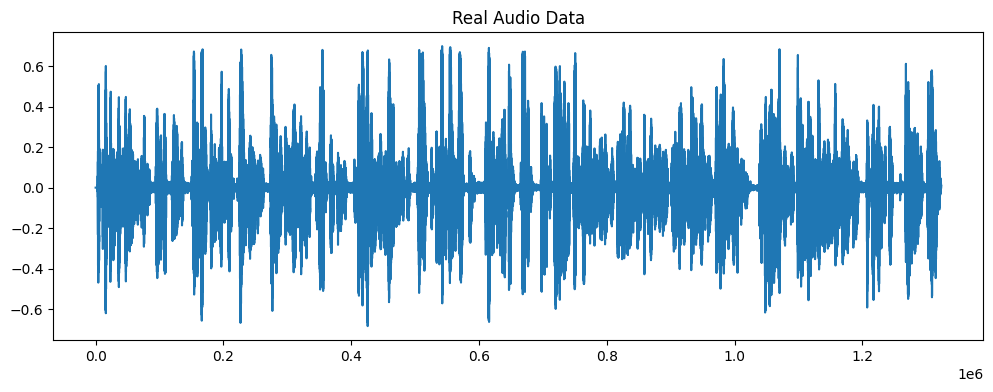

In [ ]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()

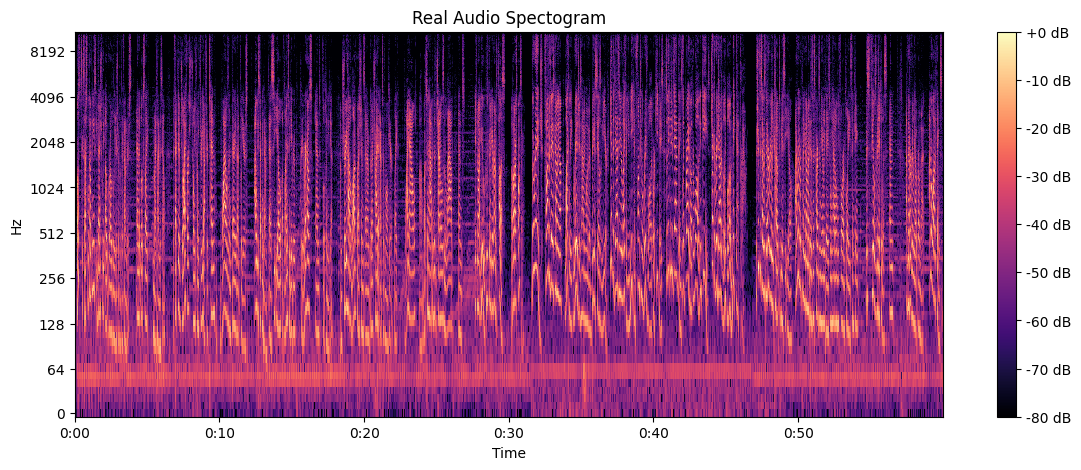

In [ ]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()

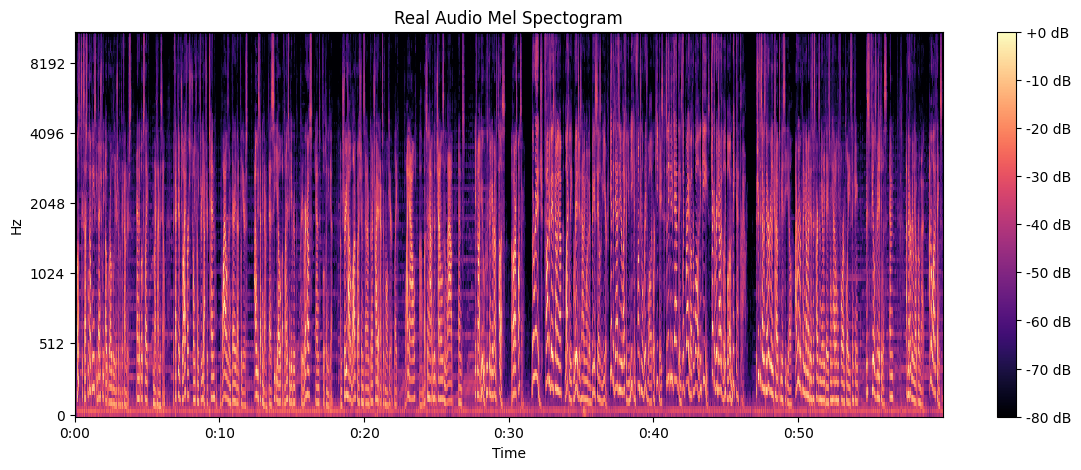

In [ ]:
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

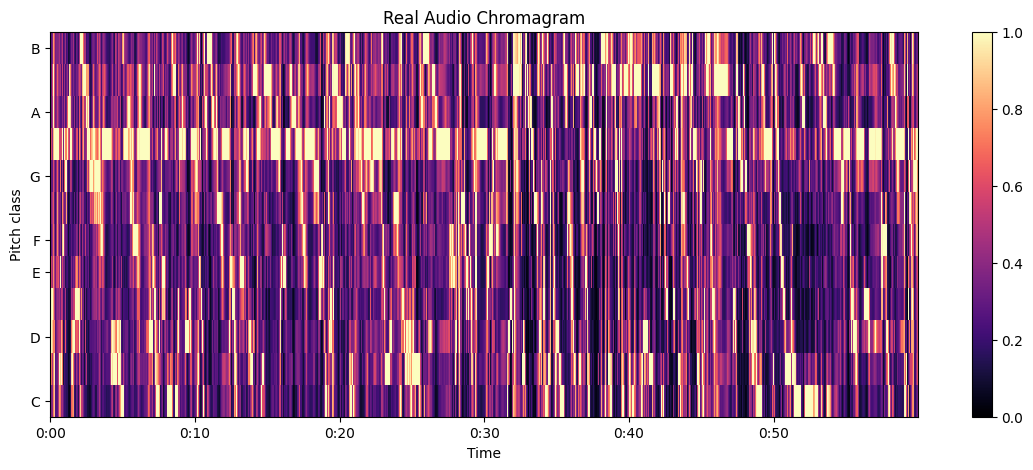

In [ ]:
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")
plt.show()

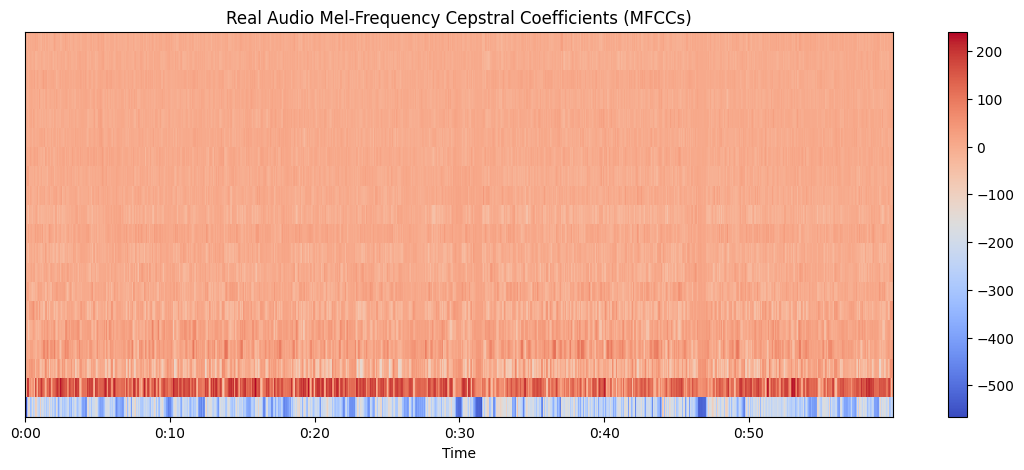

In [ ]:
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

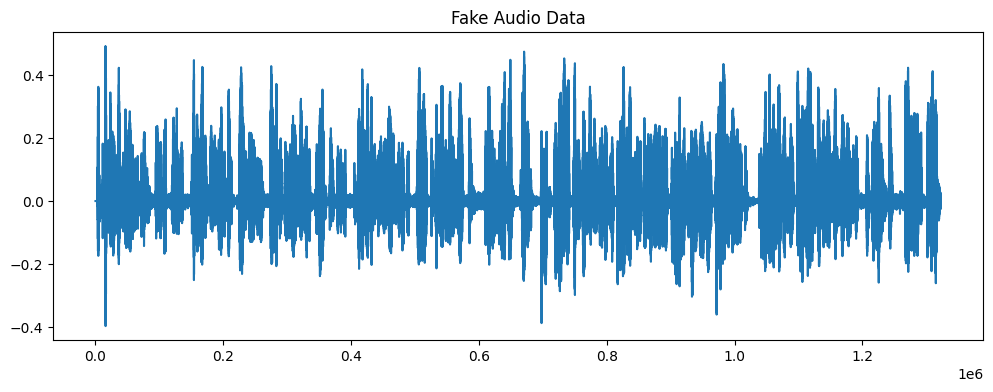

In [ ]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

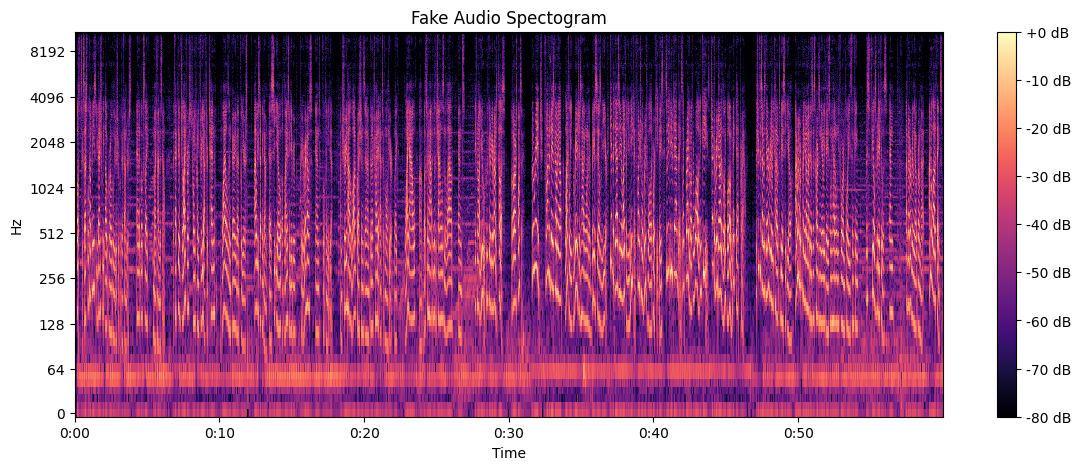

In [ ]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

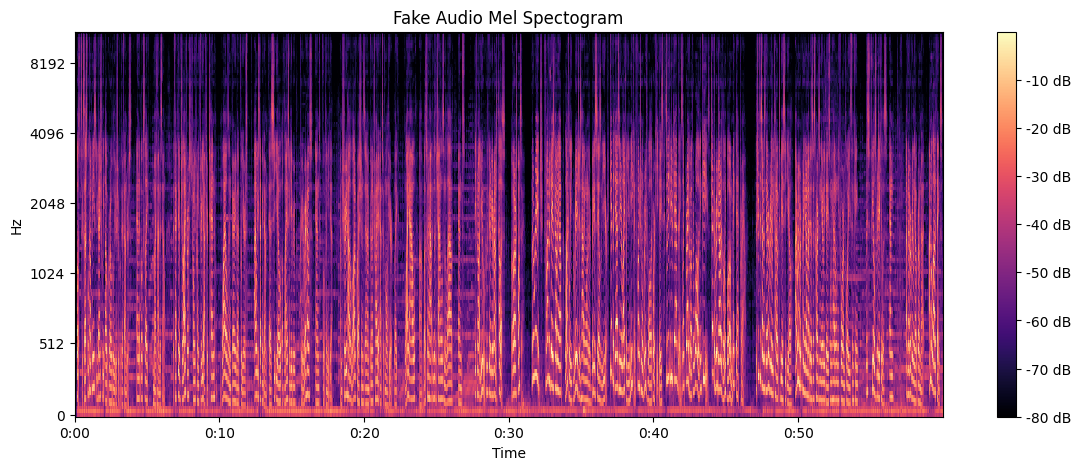

In [ ]:
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time")
plt.title("Fake Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

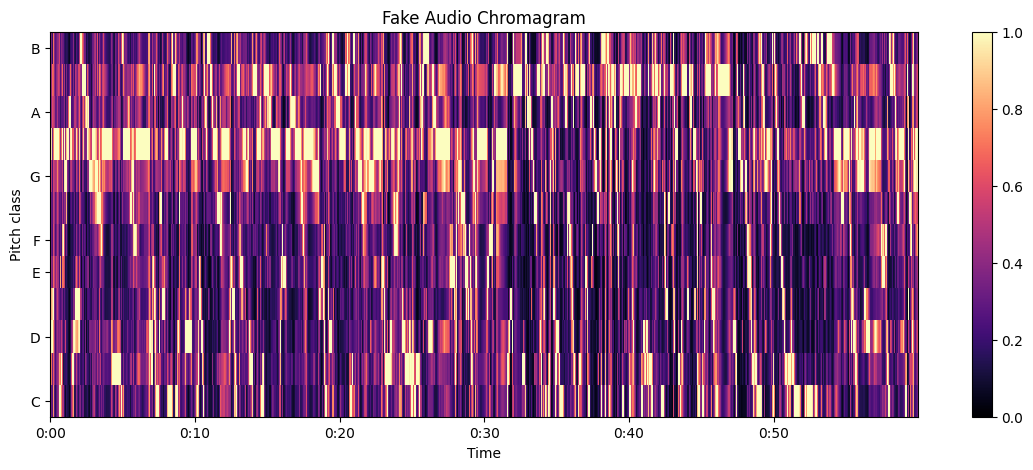

In [ ]:
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")
plt.show()

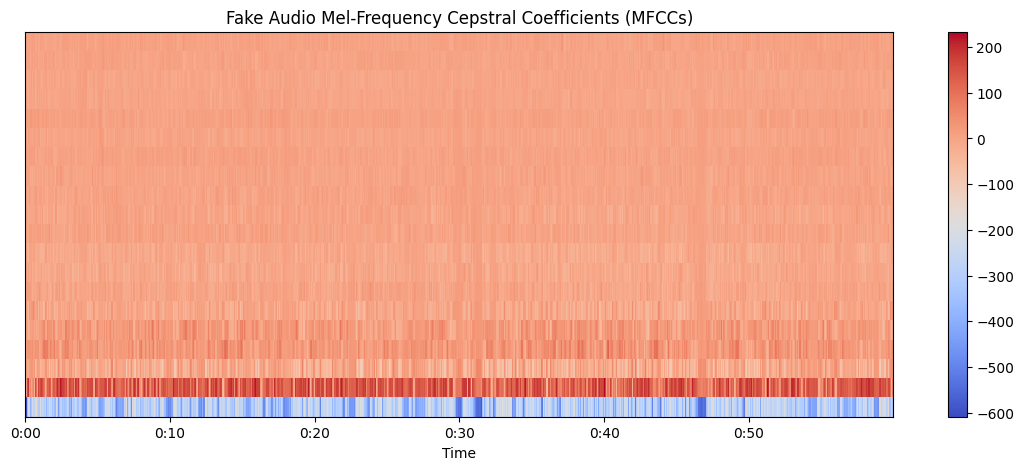

In [ ]:
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

# Preprocess using VGGish

In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tqdm import tqdm

audio_files_path = "/content/test_audio/AUDIO"
folders = os.listdir(audio_files_path)
print(folders)

vggish_model = hub.load("https://tfhub.dev/google/vggish/1")

def preprocess_audio(audio, sample_rate):
    # Resample to 16kHz for VGGish
    if sample_rate != 16000:
        audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=16000)
    return audio

data = []
labels = []


for folder in folders:
    folder_path = os.path.join(audio_files_path, folder)
    files = os.listdir(folder_path)

    for file in tqdm(files):
        file_path = os.path.join(folder_path, file)

        try:
            audio, sample_rate = librosa.load(file_path, sr=None, res_type="kaiser_fast")

            # Preprocess audio for VGGish
            audio = preprocess_audio(audio, sample_rate)

            # VGGish requires a 1-D array of shape (N,) for input
            audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

            # Extract VGGish features
            features = vggish_model(audio_tensor)
            features_np = features.numpy()

            # Flatten the features to 1D if necessary
            # Ensure all feature vectors have the same length
            # by padding or truncating them
            desired_length = 128  # Or any desired length

            # Pad shorter vectors with zeros
            if features_np.shape[0] < desired_length:
                features_np = np.pad(features_np, ((0, desired_length - features_np.shape[0]), (0, 0)), 'constant')

            # Truncate longer vectors
            features_np = features_np[:desired_length, :]

            data.append(features_np.flatten())
            labels.append(folder)  # Use folder name as label

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")


['FAKE', 'REAL']


100%|██████████| 8/8 [02:38<00:00, 19.84s/it]

Data shape: (64, 16384)
Labels shape: (64,)


In [ ]:
# Flatten the features to ensure each is a 1D array
data_flattened = np.array([feature.flatten() for feature in data])

# Create a DataFrame from the flattened features and labels
feature_df = pd.DataFrame({"features": list(data_flattened), "class": labels})

# Display the first few rows of the DataFrame
feature_df.head()

,features,class
0,"[0.05534774, 0.0050278306, 0.0076309144, -0.71...",FAKE
1,"[-0.11704555, 0.014783829, 0.21436085, -0.9680...",FAKE
2,"[-0.266328, -0.107753396, -0.03216523, -0.3997...",FAKE
3,"[-0.18518457, -0.011068195, 0.06179899, -0.949...",FAKE
4,"[-0.071603894, 0.18559343, 0.054205567, -0.403...",FAKE


In [ ]:
feature_df["class"].value_counts()

,count
class,
FAKE,56
REAL,8


In [ ]:
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

In [ ]:
feature_df["class"] = label_encoder(feature_df["class"])

class ['FAKE' 'REAL']


# Feature Scaling

In [ ]:
X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [ ]:
y_resampled = to_categorical(y_resampled)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
num_labels = len(feature_df["class"].unique())
num_labels

2

In [ ]:
input_shape = feature_df["features"][0].shape
input_shape

(16384,)

# Model

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=input_shape))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation(activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,163,458 (8.25 MB)

 Trainable params: 2,163,458 (8.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early = EarlyStopping(monitor="val_loss", patience=5)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2, epochs=100, callbacks=[early])

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8882 - loss: 0.1606 - val_accuracy: 0.9130 - val_loss: 0.0982
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8710 - loss: 0.1953 - val_accuracy: 0.9130 - val_loss: 0.0983
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9223 - loss: 0.1562 - val_accuracy: 0.9130 - val_loss: 0.1000
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9111 - loss: 0.1696 - val_accuracy: 0.9130 - val_loss: 0.1019
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9001 - loss: 0.1712 - val_accuracy: 0.9130 - val_loss: 0.1025
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8821 - loss: 0.1906 - val_accuracy: 0.9130 - val_loss: 0.1025


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9130 - loss: 0.1025
Test Loss: 0.10254655033349991
Test Accuracy: 0.9130434989929199


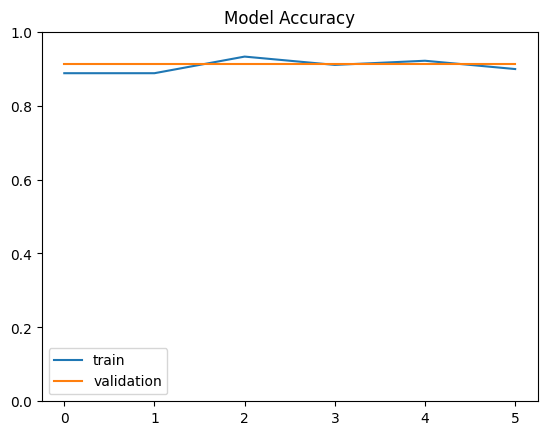

In [ ]:
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

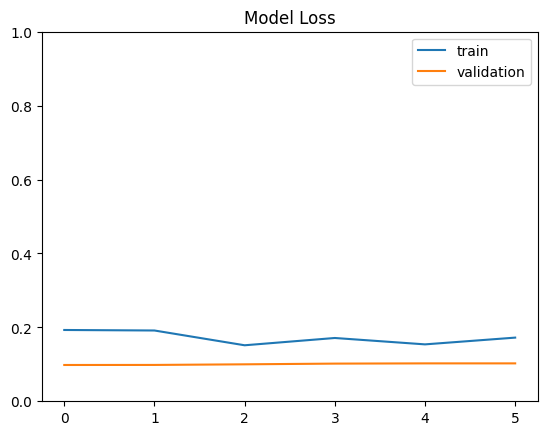

In [ ]:
plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# Test

In [ ]:
def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")

    # Reshape or pad audio data to have the expected number of features
    # Assume your model expects a 1D input
    num_expected_features = 16384  # Replace with the correct value

    # Pad with zeros if the audio is shorter
    if len(sound_signal) < num_expected_features:
        sound_signal = np.pad(sound_signal, (0, num_expected_features - len(sound_signal)), 'constant')
    # Trim if the audio is longer
    else:
        sound_signal = sound_signal[:num_expected_features]

    # The input to the model should have the correct shape
    # Here we assume the model expects a 1D input
    sound_signal = sound_signal.reshape(1, -1)

    result_array = model.predict(sound_signal)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

In [ ]:
test_real = "/content/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
test_fake = "/content/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

In [ ]:
detect_fake(test_real)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.4905791 0.5094209]]
Result: REAL


In [ ]:
detect_fake(test_fake)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.38390648 0.61609346]]
Result: REAL
